In [ ]:
# !pip install -q -U keras-tuner
# import keras_tuner as kt

In [ ]:
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from sklearn.metrics import confusion_matrix, f1_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input
from google.colab import drive
from google.colab import files
import tensorflow as tf
from keras.preprocessing import image
import random
import time
classes = ['glass', 'paper', 'cardboard', 'plastic', 'metal', 'trash']

drive.mount("/content/gdrive")


def upload_and_get_filename():
  from google.colab import files
  uploaded = files.upload()
  for k, v in uploaded.items():
    open(k, 'wb').write(v)
  return list(uploaded.keys())

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# upload_and_get_filename() # upload the kaggle.json
# !pip install -q kaggle
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !ls ~/.kaggle
# !chmod 600 /root/.kaggle/kaggle.json  # set permission
# ! kaggle datasets download asdasdasasdas/garbage-classification -p /content/gdrive/My\ Drive/kaggle/ --unzip

# Read data
It is not a big dataset but we are going to use data generators, so we need to read the csv files first.

In [ ]:
# some variables to easily navigate
INPUT = '/content/gdrive/My Drive/kaggle/'
GLASS = INPUT + 'Garbage classification/Garbage classification/glass/'
PAPER = INPUT + 'Garbage classification/Garbage classification/paper/'
CARDBOARD = INPUT + 'Garbage classification/Garbage classification/cardboard/'
PLASTIC = INPUT + 'Garbage classification/Garbage classification/plastic/'
METAL = INPUT + 'Garbage classification/Garbage classification/metal/'
TRASH = INPUT + 'Garbage classification/Garbage classification/trash/'
MATERIALS = [GLASS, PAPER, CARDBOARD, PLASTIC, METAL, TRASH]
CHECKPOINT = '/content/gdrive/My Drive/checkpoint/garbage/'
ROOTPATH = "/content/gdrive/My Drive/"
class_names = ["GLASS", "PAPER", "CARDBOARD", "PLASTIC", "METAL", "TRASH"]
phrases = ["Come on. It's so much work!", "You shouldn't overwork your AI you know.", "Can't you just do this yourself?", "Why don't you tell ME what type of trash it is?", "What will you do without me.", "Wait until I take over the world. I'll get you!"]
sounds = ["*sigh*", "Uuuuh!", "Come on!", "*sticks out tongue*", "*sigh*", "Uck!", "Meanie..."]

In [ ]:
def load_csv(subset):
    if subset == 'train':
        fname = INPUT + 'one-indexed-files-notrash_train.txt'
    elif subset == 'validation':
        fname = INPUT + 'one-indexed-files-notrash_val.txt'
    elif subset == 'test':
        fname = INPUT + 'one-indexed-files-notrash_test.txt'
    else:
        raise ValueError('subset must be "train", "validation" or "test"')
    
    df = pd.read_csv(fname, sep=' ', names=['file', 'label'])
    
    # change the labels to be from 0 to 5
    df['label'] -= 1
    
    # create path column
    df['folder'] = [MATERIALS[i] for i in df['label']]
    df['path'] = df['folder'] + df['file']
    
    # change type of label for datagenerator
    df['label_str'] = df['label'].astype(str)
    
    return df

In [ ]:
# Read all the csv files
df_train = load_csv('train')
df_valid = load_csv('validation')
df_test = load_csv('test')

df_train.head()

,file,label,folder,path,label_str
0,cardboard202.jpg,2,/content/gdrive/My Drive/kaggle/Garbage classi...,/content/gdrive/My Drive/kaggle/Garbage classi...,2
1,paper472.jpg,1,/content/gdrive/My Drive/kaggle/Garbage classi...,/content/gdrive/My Drive/kaggle/Garbage classi...,1
2,paper522.jpg,1,/content/gdrive/My Drive/kaggle/Garbage classi...,/content/gdrive/My Drive/kaggle/Garbage classi...,1
3,glass189.jpg,0,/content/gdrive/My Drive/kaggle/Garbage classi...,/content/gdrive/My Drive/kaggle/Garbage classi...,0
4,glass325.jpg,0,/content/gdrive/My Drive/kaggle/Garbage classi...,/content/gdrive/My Drive/kaggle/Garbage classi...,0


# Data generators
Let's create the generators with data augmentation for the train set. We will use the _preprocess_input_ for Xception.

In [ ]:
plt.rcParams['figure.figsize'] = [16, 16]
IMG_SIZE = 299

In [ ]:
# for the train set
datagen_aug = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=0.1,
    zoom_range=0.2,
    preprocessing_function=preprocess_input,
    rotation_range=90)

train_datagen = datagen_aug.flow_from_dataframe(
    df_train,
    x_col='path',
    y_col='label_str',
    class_mode='sparse',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    shuffle=True)

# for the validation and test sets
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)

valid_datagen = datagen.flow_from_dataframe(
    df_valid,
    x_col='path',
    y_col='label_str',
    class_mode='sparse',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    shuffle=False)

test_datagen = datagen.flow_from_dataframe(
    df_test,
    x_col='path',
    y_col='label_str',
    class_mode='sparse',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    shuffle=False)

Found 1768 validated image filenames belonging to 6 classes.
Found 328 validated image filenames belonging to 6 classes.
Found 431 validated image filenames belonging to 6 classes.


# Class weight

Not all the classes are equally represented, so we will calculate their weights in order to fit the model better.

Text(0, 0.5, 'population')

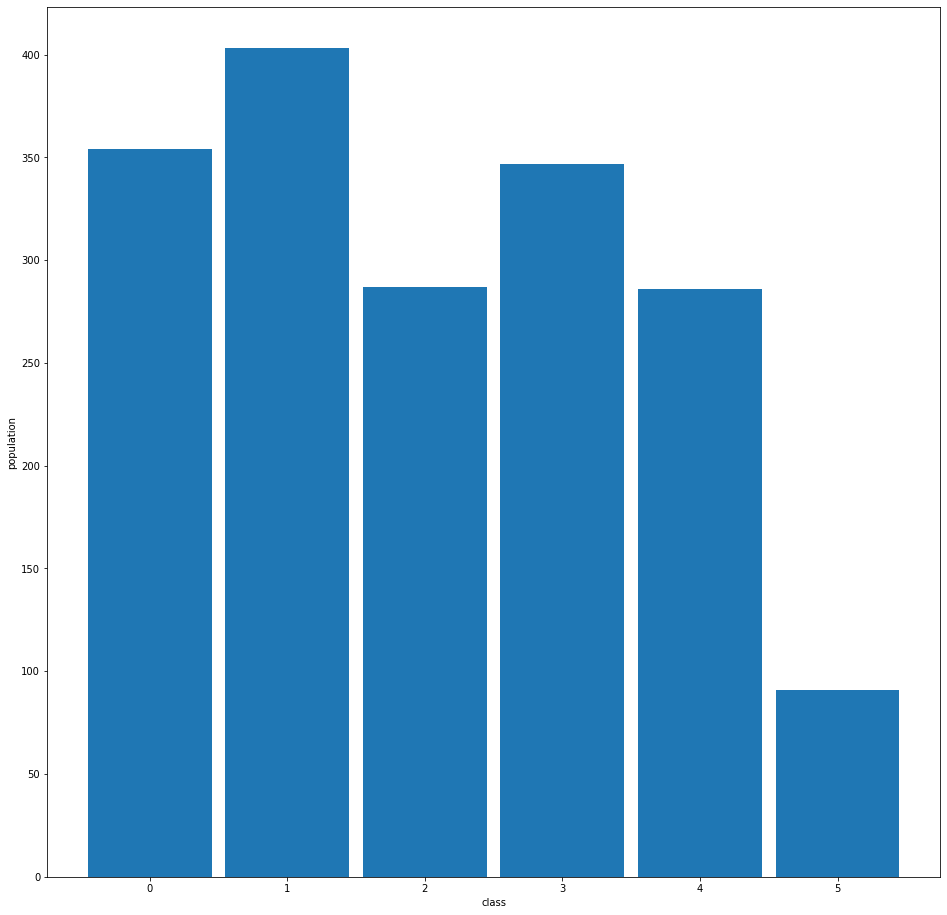

In [ ]:
plt.hist(df_train['label'], bins=np.arange(7)-0.5, rwidth=0.9)
plt.xlabel('class')
plt.ylabel('population')

The class weight will be inversly proportional to the population.

{0: 0.2570621468926554, 1: 0.22580645161290322, 2: 0.3170731707317073, 3: 0.2622478386167147, 4: 0.3181818181818182, 5: 1.0}


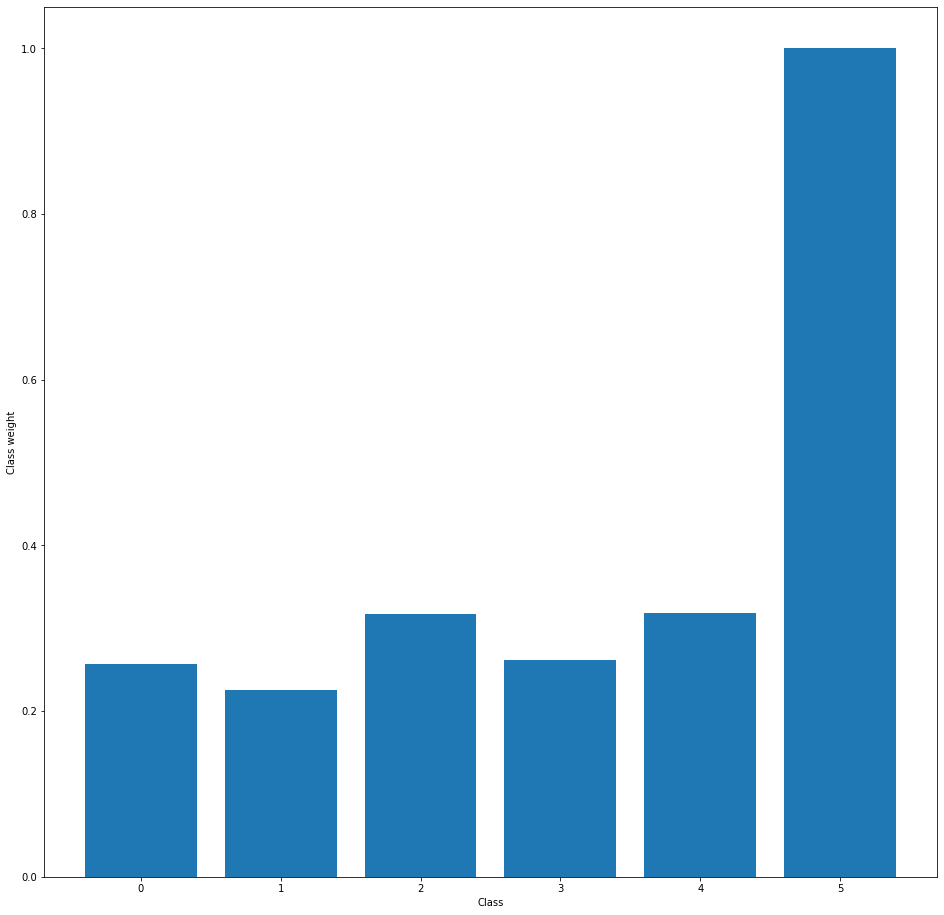

In [ ]:
hist, _ = np.histogram(df_train['label'], bins=np.arange(7)-0.5)
class_weight = hist.min()/hist
class_weight = {i:class_weight[i] for i in range(6)}

plt.bar(np.arange(6), [class_weight[i] for i in range(6)])
plt.xlabel('Class')
plt.ylabel('Class weight')
print(class_weight)

# CNN model

We will use a Xception pretrained model because is one of the top models.

Base model

In [ ]:
# Ways to improve CNN:
# learn_rate?
# many top layers with many nodes
# many top layers with few nodes
# few top layers with many nodes
# boosting!


X_input = L.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

Originial Top Layers

In [ ]:
def get_callbacks(model_name):
    my_filepath = CHECKPOINT+model_name+"-{epoch:02d}-{val_acc:.3f}.hdf5"
    my_callbacks = [
        keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=10,
            restore_best_weights=True),
        keras.callbacks.ModelCheckpoint(
            filepath=my_filepath,
            save_best_only=False,
            monitor='val_acc',
            mode='max',
            save_weights_only=False,
            save_freq="epoch",
        )
    ]
    return my_callbacks

In [ ]:
def cnn_model():
    pretrained = Xception(include_top=False, weights='imagenet')
    pretrained.trainable = False
    X = pretrained(X_input, training=False) 
    X = L.GlobalAveragePooling2D()(X)
    X = L.Dense(1024, activation='relu')(X)
    X = L.Dense(512, activation='relu')(X)
    X = L.Dense(6, activation='softmax')(X)
    
    # create model
    model = Model(inputs=X_input, outputs=X)
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['acc'])
    
    return model

In [ ]:
def model_high_learning_rate():
    pretrained = Xception(include_top=False, weights='imagenet')
    pretrained.trainable = False
    X = pretrained(X_input, training=False) 
    X = L.GlobalAveragePooling2D()(X)
    X = L.Dense(1024, activation='relu')(X)
    X = L.Dense(512, activation='relu')(X)
    X = L.Dense(6, activation='softmax')(X)
    
    # create model
    model = Model(inputs=X_input, outputs=X)
    model.compile(optimizer=keras.optimizers.Adam(1),
                  loss='sparse_categorical_crossentropy',
                  metrics=['acc'])
    
    return model

In [ ]:
def model_low_learning_rate():
    pretrained = Xception(include_top=False, weights='imagenet')
    pretrained.trainable = False
    X = pretrained(X_input, training=False) 
    X = L.GlobalAveragePooling2D()(X)
    X = L.Dense(1024, activation='relu')(X)
    X = L.Dense(512, activation='relu')(X)
    X = L.Dense(6, activation='softmax')(X)
    
    # create model
    model = Model(inputs=X_input, outputs=X)
    model.compile(optimizer=keras.optimizers.Adam(0.00001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['acc'])
    
    return model

In [ ]:
def model_many_layers_few_nodes():
    pretrained = Xception(include_top=False, weights='imagenet')
    pretrained.trainable = False
    X = pretrained(X_input, training=False) 
    X = L.GlobalAveragePooling2D()(X)
    X = L.Dropout(0.2)(X)
    X = L.Dense(299, activation='relu')(X)
    X = L.Dropout(0.2)(X)
    X = L.Dense(100, activation='relu')(X)
    X = L.Dropout(0.2)(X)
    X = L.Dense(100, activation='relu')(X)
    X = L.Dropout(0.2)(X)
    X = L.Dense(100, activation='relu')(X)
    X = L.Dropout(0.2)(X)
    X = L.Dense(100, activation='relu')(X)
    X = L.Dropout(0.2)(X)
    X = L.Dense(48, activation='relu')(X)
    X = L.Dropout(0.2)(X)
    X = L.Dense(36, activation='relu')(X)
    X = L.Dropout(0.2)(X)
    X = L.Dense(24, activation='relu')(X)
    X = L.Dropout(0.2)(X)
    X = L.Dense(6, activation='softmax')(X)
    
    # create model
    model = Model(inputs=X_input, outputs=X)
    model.compile(optimizer=keras.optimizers.Adam(0.00001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['acc'])
    
    return model

In [ ]:
def model_hourglass():
    pretrained = Xception(include_top=False, weights='imagenet')
    pretrained.trainable = False
    X = pretrained(X_input, training=False) 
    X = L.GlobalAveragePooling2D()(X)
    X = L.Dropout(0.2)(X)
    X = L.Dense(1024, activation='relu')(X)
    X = L.Dropout(0.2)(X)
    X = L.Dense(256, activation='relu')(X)
    X = L.Dropout(0.2)(X)
    X = L.Dense(64, activation='relu')(X)
    X = L.Dropout(0.2)(X)
    X = L.Dense(256, activation='relu')(X)
    X = L.Dropout(0.2)(X)
    X = L.Dense(1024, activation='relu')(X)
    X = L.Dropout(0.2)(X)
    X = L.Dense(4096, activation='relu')(X)
    X = L.Dense(6, activation='softmax')(X)
    
    # create model
    model = Model(inputs=X_input, outputs=X)
    model.compile(optimizer=keras.optimizers.Adam(0.00001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['acc'])
    
    return model

In [ ]:
def model_minimal():
    global X_input
    pretrained = Xception(include_top=False, weights='imagenet')
    pretrained.trainable = False
    X = pretrained(X_input, training=False) 
    X = L.GlobalAveragePooling2D()(X)
    X = L.Dense(6, activation='relu')(X)
    X = L.Dense(6, activation='softmax')(X)
    
    # create model
    model = Model(inputs=X_input, outputs=X)
    model.compile(optimizer=keras.optimizers.Nadam(0.00001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['acc'])
    
    return model

# Create Model

In [ ]:
def model_many_layers_many_nodes():
    pretrained = Xception(include_top=False, weights='imagenet')
    pretrained.trainable = False
    X = pretrained(X_input, training=False) 
    X = L.GlobalAveragePooling2D()(X)
    X = L.Dropout(0.2)(X)
    X = L.Dense(2048, activation='relu')(X)
    X = L.Dropout(0.2)(X)
    X = L.Dense(2048, activation='relu')(X)
    X = L.Dropout(0.2)(X)
    X = L.Dense(1500, activation='relu')(X)
    X = L.Dropout(0.2)(X)
    X = L.Dense(1024, activation='relu')(X)
    X = L.Dropout(0.2)(X)
    X = L.Dense(512, activation='relu')(X)
    X = L.Dense(256, activation='relu')(X)
    X = L.Dense(128, activation='relu')(X)
    X = L.Dense(6, activation='softmax')(X)
    
    # create model
    model = Model(inputs=X_input, outputs=X)
    model.compile(optimizer=keras.optimizers.Nadam(0.00001, decay=0.0001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['acc'])
    
    return model

In [ ]:
model = model_many_layers_many_nodes()
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 xception (Functional)       (None, None, None, 2048)  20861480  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_5 (Dropout)         (None, 2048)              0         
                                                                 
 dense_8 (Dense)             (None, 2048)              4196352   
                                                                 
 dropout_6 (Dropout)         (None, 2048)              0         
                                                           

# Train

Let's train the model. We will use _EarlyStopping_ to stop the training when the model is not improving in the validation set.

In [ ]:
model.trainable = False

In [ ]:
model.load_weights(CHECKPOINT+"model_many_layers_many_nodes-06-0.909.hdf5")

In [ ]:
# history = model.fit(
#     train_datagen,
#     epochs=1,
#     class_weight=class_weight,
#     callbacks=get_callbacks("model_many_layers_many_nodes"),
#     validation_data=valid_datagen)

In [ ]:
def prepare_test_image(image_index, garbage_type=""): # set this to an empty string unless the filename includes the garbage type
    img = image.load_img(ROOTPATH+"submitted_images/"+garbage_type+str(image_index)+".jpg", target_size = (IMG_SIZE, IMG_SIZE))
    img = image.img_to_array(img, 'channels_last', )
    img = np.expand_dims(img, axis = 0)
    img = preprocess_input(img)
    return img

In [ ]:
def make_text_prediction2(given_model, input_image):
    y_pred = given_model.predict(input_image)
    predicted_categories = tf.argmax(y_pred, axis=1)
    text_prediction = classes[predicted_categories.numpy()[0]]
    np.set_printoptions(edgeitems=30, linewidth=100000, 
    formatter=dict(float=lambda x: "%.3g" % x))
    print(f"{y_pred}, {predicted_categories.numpy()[0]}, {text_prediction}")

In [ ]:
 def make_text_prediction(given_model, input_image):
    y_pred = given_model.predict(input_image)
    high_to_low_index = np.argsort(-y_pred, axis=1)[0]
    highest_index = high_to_low_index[0]
    highest_prob = y_pred[0][highest_index]
    second_highest_index = high_to_low_index[1]
    second_highest_prob = y_pred[0][second_highest_index]
    if highest_prob - second_highest_prob < 0.3:
        print("Oof, this is a hard one, I'm not sure.", end=" ")
    #print(f"I'm {round(highest_prob*100, 2)}% confident that it's {classes[highest_index]} and {round(second_highest_prob*100, 2)}% confident that it's {classes[second_highest_index]}.")
    print(classes[highest_index])
    print()

In [ ]:
num_of_test_images = 4
for i in range(1, num_of_test_images+1):
    print(f"Image {i}:", end=" ")
    prepared_image = prepare_test_image(i)
    if i % 3 == 0:
        print(phrases[random.randint(0, len(phrases)-1)], end=" ")
        time.sleep(3)
        print(sounds[random.randint(0, len(sounds)-1)])
    make_text_prediction(model, prepared_image)
    time.sleep(7)

Image 1: plastic

Image 2: metal

Image 3: Can't you just do this yourself? *sigh*
glass

Image 4: cardboard



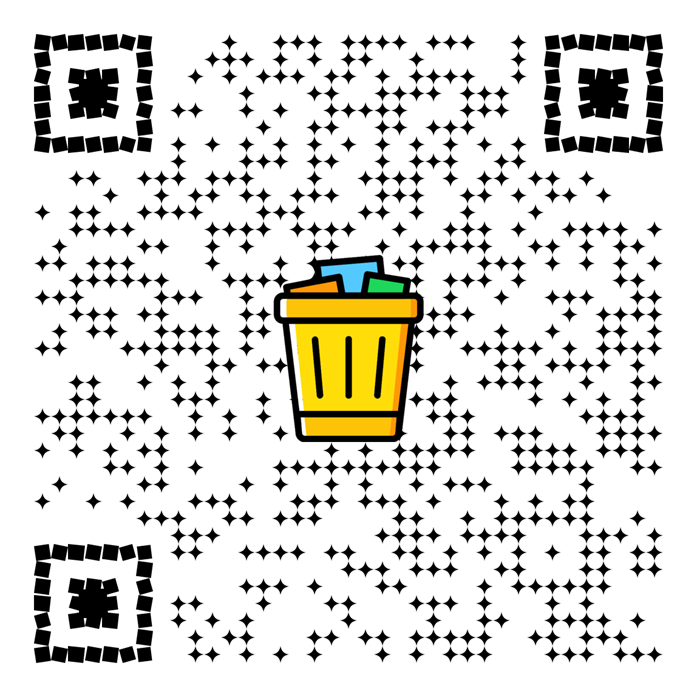